## Imports

In [1]:
from skimage.metrics import structural_similarity
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2

## Add Noise

In [12]:
img = cv2.imread("/content/drive/MyDrive/Einstein.jpg", 0)
print(img.shape)

(286, 230)


True

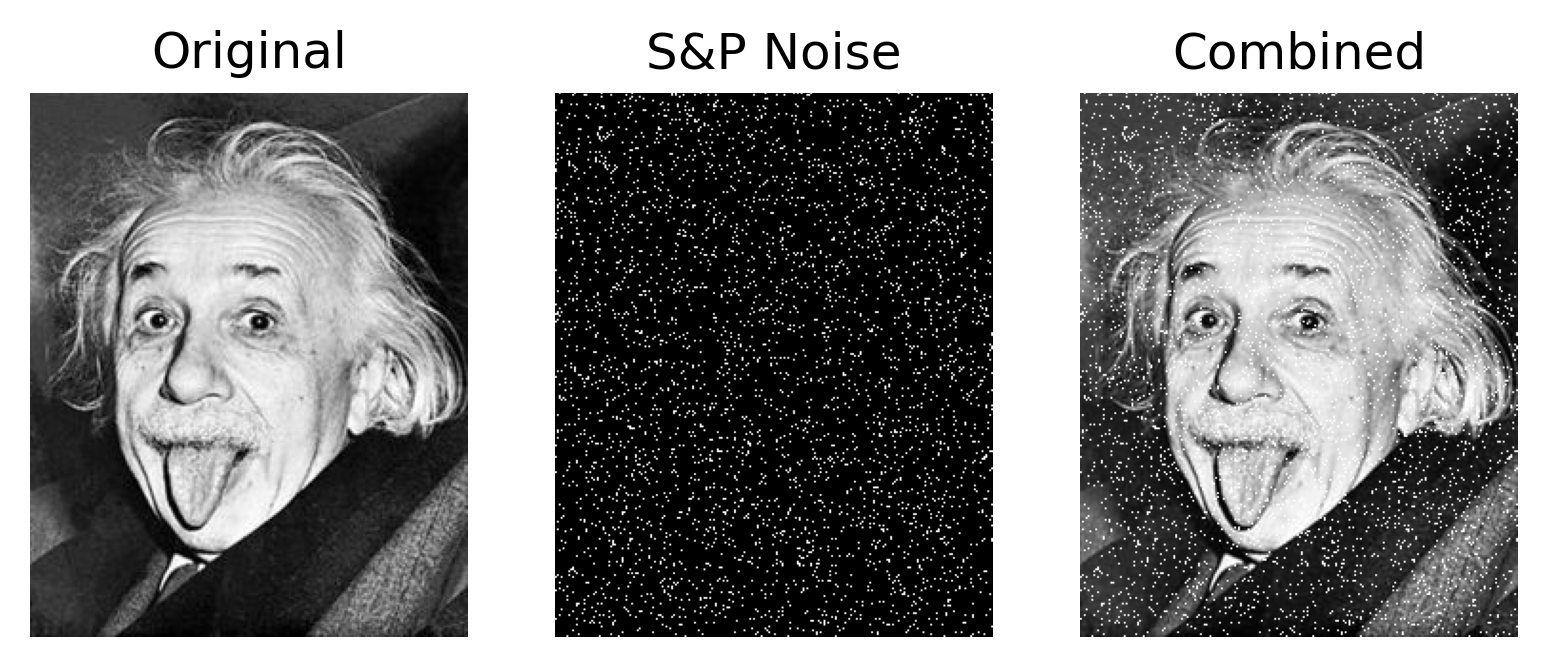

In [13]:
# Salt and Pepper Noise
sp_noise = np.zeros((286,230),dtype=np.uint8)
cv2.randu(sp_noise,0,255)
sp_noise = cv2.threshold(sp_noise,240,255,cv2.THRESH_BINARY)[1]
sp_noise_img = cv2.add(img, sp_noise)

fig=plt.figure(dpi=300)

fig.add_subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,3,2)
plt.imshow(sp_noise, cmap='gray')
plt.axis("off")
plt.title("S&P Noise")

fig.add_subplot(1,3,3)
plt.imshow(sp_noise_img, cmap='gray')
plt.axis("off")
plt.title("Combined")

cv2.imwrite("/content/drive/MyDrive/SP.jpg", sp_noise)
cv2.imwrite("/content/drive/MyDrive/Einstein_SP.jpg", sp_noise_img)

True

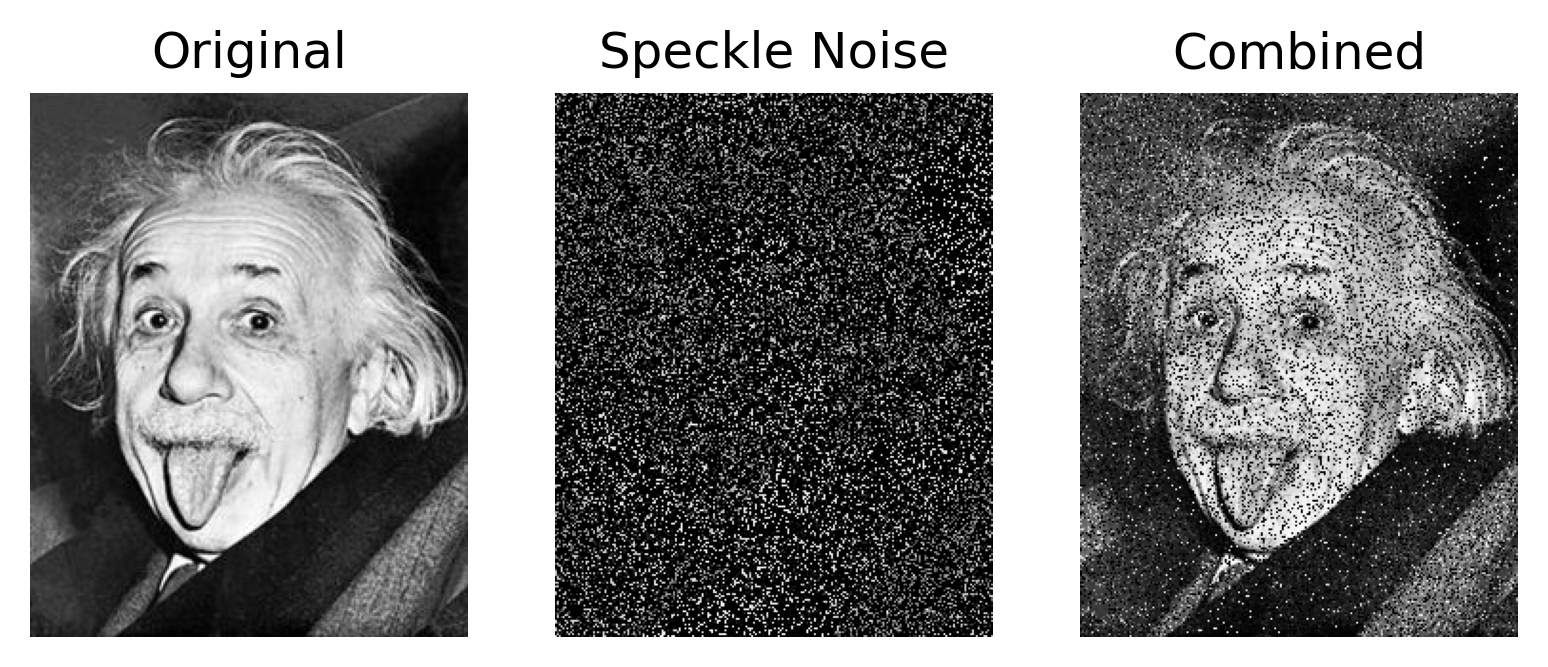

In [14]:
# Speckle noise
gauss = np.random.normal(0,1,img.shape)
gauss = gauss.reshape(img.shape[0],img.shape[1]).astype('uint8')
speckle_noise_img = img + img * gauss

fig=plt.figure(dpi=300)

fig.add_subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,3,2)
plt.imshow(img*gauss, cmap='gray')
plt.axis("off")
plt.title("Speckle Noise")

fig.add_subplot(1,3,3)
plt.imshow(speckle_noise_img, cmap='gray')
plt.axis("off")
plt.title("Combined")

#cv2.imwrite("/content/drive/MyDrive/Speckle.jpg", img*gauss)
cv2.imwrite("/content/drive/MyDrive/Einstein_Speckle.jpg", speckle_noise_img)

## Anisotropic Diffusion

In [85]:
def mean_sqr_err(img1, img2):
  err = np.sum((img1.astype("float") - img2.astype("float")) ** 2)
  err /= float(img1.shape[0] * img1.shape[1])
  return err 


def anisodiff(image, K, it, l, n_type):
  image = cv2.normalize(image, None, 0, 1.0,cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  m, n = image.shape

  rowN, rowS = list(range(0,m-1)), list(range(1,m))
  rowN.insert(0, 0)
  rowS.insert(m, m-1)
  
  colE, colW = list(range(0,n-1)), list(range(1,n))
  colE.insert(0,0)
  colW.insert(n, n-1)

  psnr, mse, ssim = 0, 0, 0

  for i in range(it):
    deltaN = image[rowN,] - image
    deltaE = image[:,colE] - image 

    fluxN = np.multiply(deltaN,1/(1+(abs(deltaN)/K)**2))
    fluxS = fluxN[rowS,]
    fluxE = np.multiply(deltaE,1/(1+(abs(deltaN)/K)**2))  
    fluxW = fluxE[:,colW]

    image = image + l * (fluxN - fluxS + fluxE - fluxW)    
    denorm_img = np.multiply(image, 255.0).astype('uint8')

    if i == (it-1):
      psnr = cv2.PSNR(img, denorm_img)
      mse = mean_sqr_err(img, denorm_img)
      ssim = structural_similarity(img, denorm_img)
  
  return image, psnr, mse, ssim

K = 0.05

PSNR_SP, PSNR_SPE = [], []
MSE_SP, MSE_SPE = [], []
SSIM_SP, SSIM_SPE = [], []

for i in range(20):
  denoise_sp, psnr_sp, mse_sp, ssim_sp = anisodiff(sp_noise_img, K, 20, 0.1, "S&P")
  denoise_spe, psnr_spe, mse_spe, ssim_spe = anisodiff(speckle_noise_img, K, 20, 0.1, "Speckle")
  K += 0.05
  PSNR_SP.append(psnr_sp)
  PSNR_SPE.append(psnr_spe)
  MSE_SP.append(mse_sp)
  MSE_SPE.append(mse_spe)
  SSIM_SP.append(ssim_sp)
  SSIM_SPE.append(ssim_spe)

Ks = np.arange(0.05,1.05,0.05)
Ks = Ks.tolist()

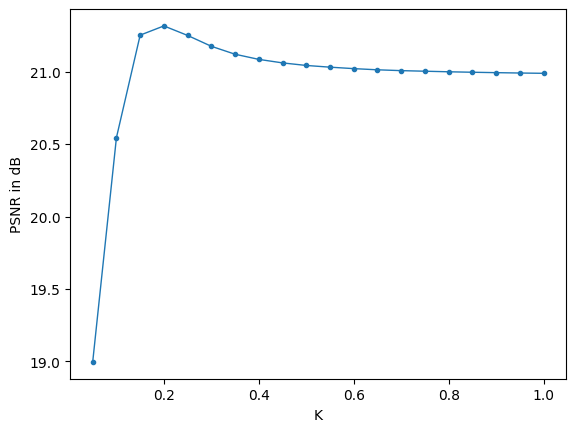

In [94]:
plt.plot(Ks, PSNR_SP, linewidth=1, marker ='.')
plt.xlabel("K")
plt.ylabel("PSNR in dB")
plt.savefig("/content/drive/MyDrive/PSNR_SP.png")

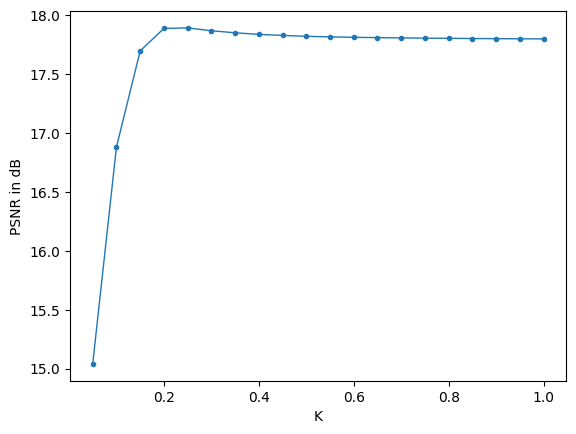

In [95]:
plt.plot(Ks, PSNR_SPE, linewidth=1, marker ='.')
plt.xlabel("K")
plt.ylabel("PSNR in dB")
plt.savefig("/content/drive/MyDrive/PSNR_SPE.png")

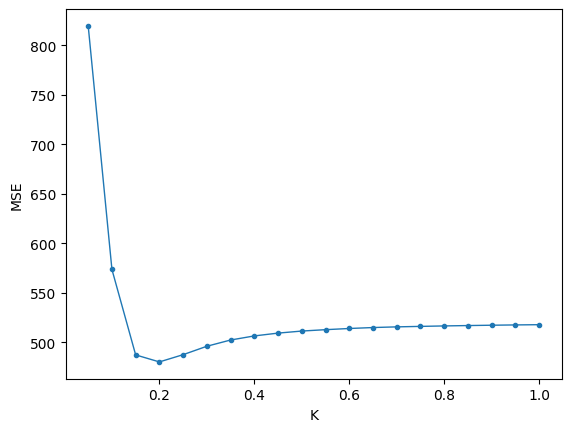

In [96]:
plt.plot(Ks, MSE_SP, linewidth=1, marker ='.')
plt.xlabel("K")
plt.ylabel("MSE")
plt.savefig("/content/drive/MyDrive/MSE_SP.png")

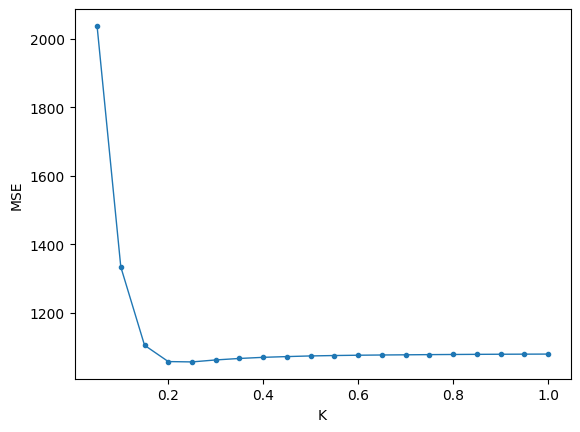

In [97]:
plt.plot(Ks, MSE_SPE, linewidth=1, marker ='.')
plt.xlabel("K")
plt.ylabel("MSE")
plt.savefig("/content/drive/MyDrive/MSE_SPE.png")

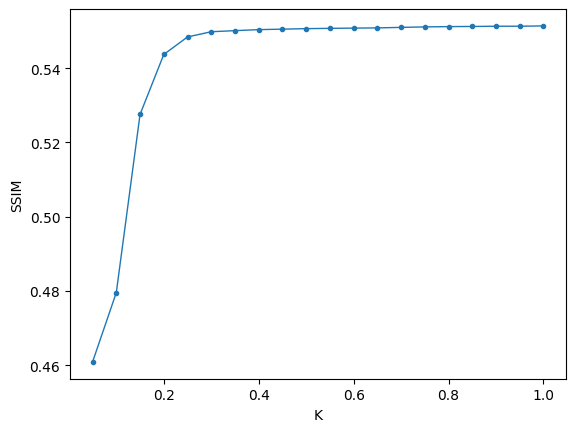

In [98]:
plt.plot(Ks, SSIM_SP, linewidth=1, marker ='.')
plt.xlabel("K")
plt.ylabel("SSIM")
plt.savefig("/content/drive/MyDrive/SSIM_SP.png")

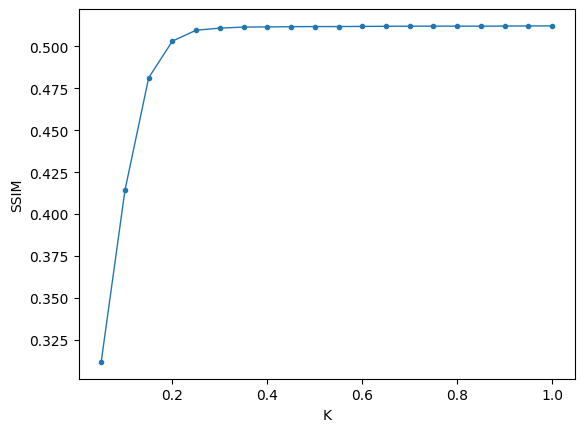

In [99]:
plt.plot(Ks, SSIM_SPE, linewidth=1, marker ='.')
plt.xlabel("K")
plt.ylabel("SSIM")
plt.savefig("/content/drive/MyDrive/SSIM_SPE.png")

Text(0.5, 1.0, 'Denoised Image')

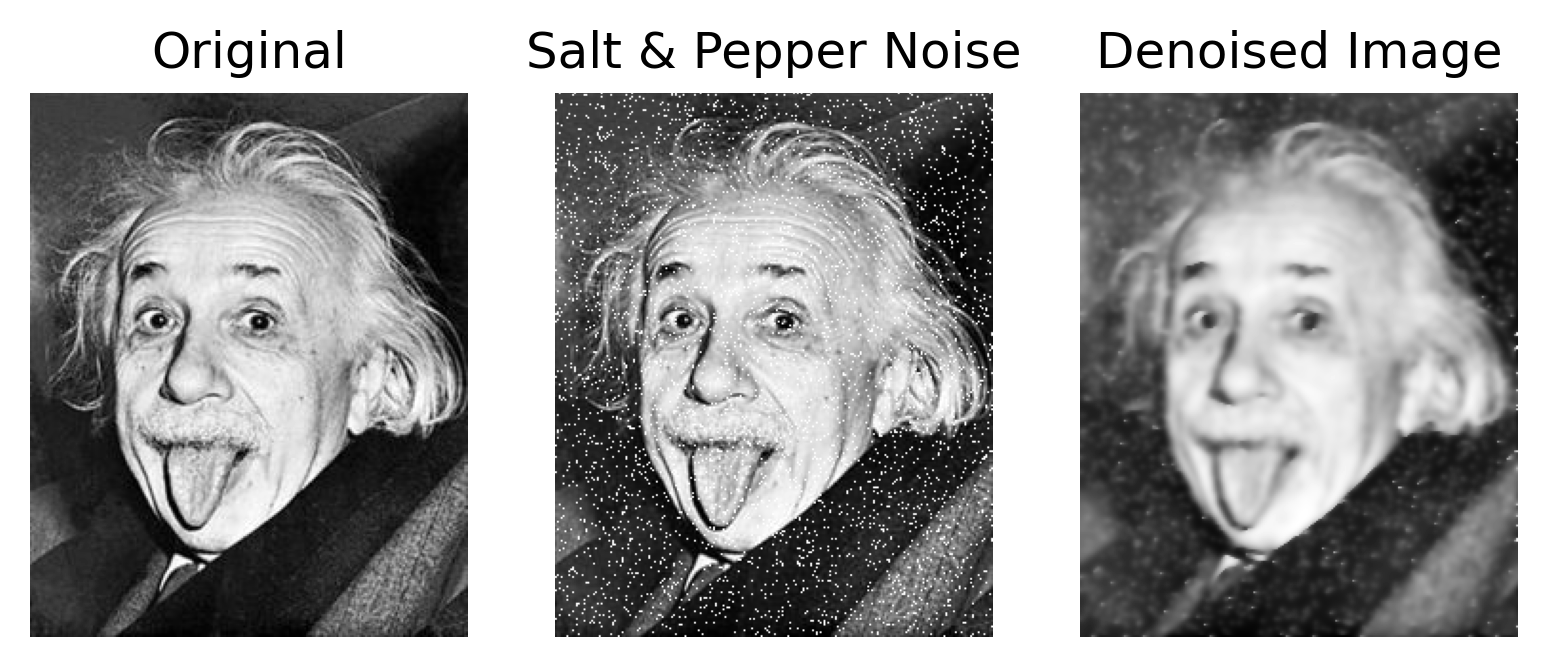

In [104]:
denoise_sp, psnr_sp, mse_sp, ssim_sp = anisodiff(sp_noise_img, 0.2, 20, 0.1, "S&P")
cv2.imwrite("/content/drive/MyDrive/Einstein_Denoise_SP.jpg", denoise_sp)


fig=plt.figure(dpi=300)

fig.add_subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,3,2)
plt.imshow(sp_noise_img, cmap='gray')
plt.axis("off")
plt.title("Salt & Pepper Noise")

fig.add_subplot(1,3,3)
plt.imshow(denoise_sp, cmap='gray')
plt.savefig("/content/drive/MyDrive/SSIM_SPE.png")
plt.axis("off")
plt.title("Denoised Image")



Text(0.5, 1.0, 'Denoised Image')

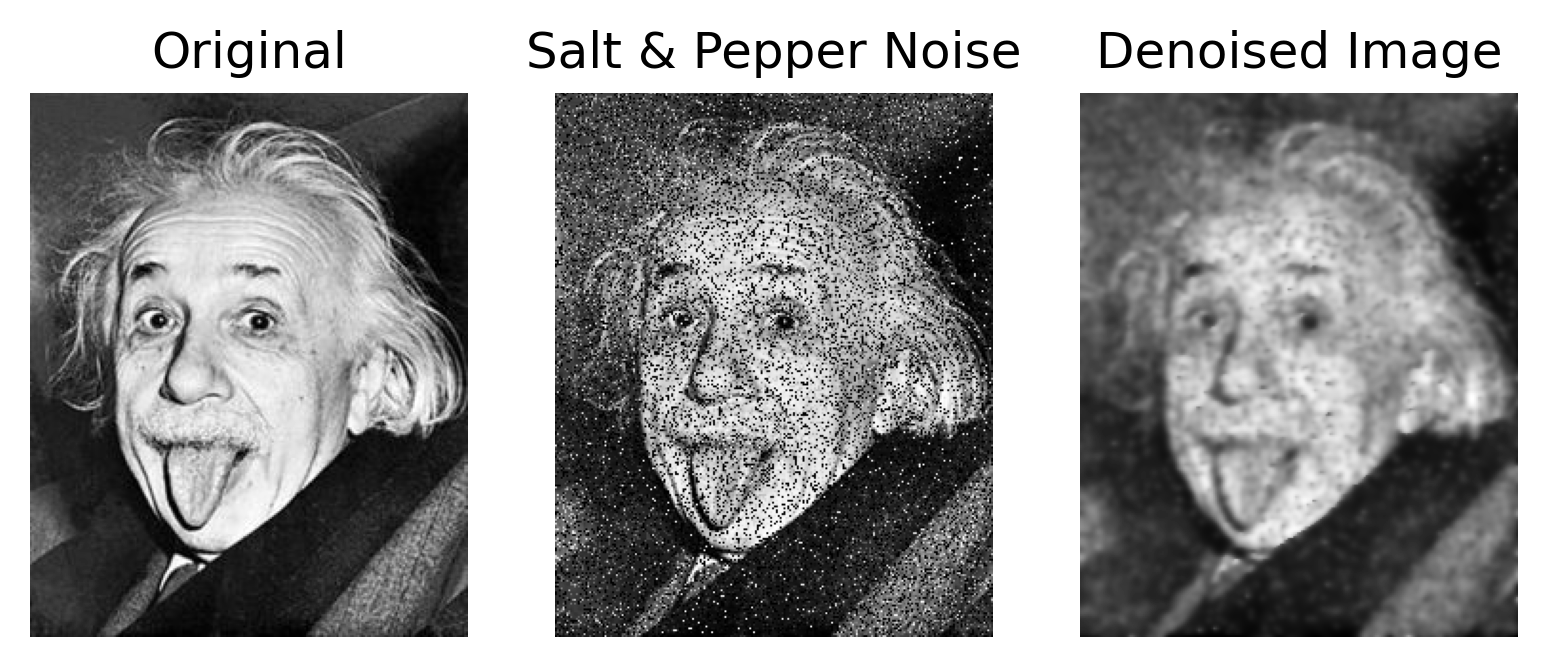

In [106]:
denoise_speckle, psnr_spe, mse_spe, ssim_spe = anisodiff(speckle_noise_img, 0.25, 20, 0.1, "Speckle")



fig=plt.figure(dpi=300)

fig.add_subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.axis("off")
plt.title("Original")

fig.add_subplot(1,3,2)
plt.imshow(speckle_noise_img, cmap='gray')
plt.axis("off")
plt.title("Salt & Pepper Noise")

fig.add_subplot(1,3,3)
plt.imshow(denoise_speckle, cmap='gray')
plt.axis("off")
plt.title("Denoised Image")